In [1]:
import matplotlib.pyplot as plt #for plotting
from matplotlib.ticker import EngFormatter #Formater of Engineering notation string
import matplotlib.ticker as mtick  #To draw vertical lines to plots
import numpy as np #numpy
from quantiphy import Quantity as qt#to format numbers 
#To add the toolbar to plots

## Introduction

* This notebook aims to exercise the block diagram of the OFDM technique for a given number of carriers to be transmitted over a channel;
* Initially, the modulation chosen will be BPSK for each carrier. In the future, QAM will also be applied;
* The application will map and input char word and will codify it into OFDM in terms of ASCII;
* The particular aspects of the D/A converter will be covered.

## System setup

The block diagram below describes the way one apply OFDM into a communication system:

<img src="OFDM_block_diagram.png" width="400" height="300" />

Sources: 

[NTU Singapore (Prof. Hsin-Mu Tsai slides)](https://www.csie.ntu.edu.tw/~hsinmu/courses/_media/wn_11fall/ofdm_new.pdf)

[Link to Prof Tsai's other courses](https://www.csie.ntu.edu.tw/~hsinmu/courses/)

[Prof. Tsai Lectures on Wireless Networking (2011)](https://www.csie.ntu.edu.tw/~hsinmu/courses/wn_11fall)

### Description

From the input data up to the D/A converter, everything is computed digitally in the transmitter, by using a digital signal processor or a microcontroller unit. Data is formatted into an OFDM symbol through an IFFT algorithm. The process is described as follows. 

The modulator selects the symbols out of a constellation to represent the input data. A Serial to Parallell converter delivers the symbols into an IFFT algorithm, that transforms the amplitudes and phases of the carriers into a time-domain signal. The signal is then formatted with a well-defined pulse (e.g., a raised-cosine pulse) that is bandlimited.


### A note on the D/A Converter

It is worth expanding what happens during the D/A conversion. A zero-order-hold (ZOH) D/A converter may be used to perform the conversion. When using a D/A that receives data through SPI communication, it implies into a making the D/A having a higher sampling frequency that can be supported by the OFDM system.

**This if it is assumed that the D/A's settling time is lower than the SPI's delay time. But this is a topic for another notebook.**

For example, for a 10 bit ZOH D/A converter using SPI to communicate to the MCU responsibile for the OFDM, each symbol would require 10 SPI clock cycles to feed the entire bit word of one single sample of the OFDM signal. 

Thus,

$ T_{s} = 10T_{\mathrm{SPI}}$,

in which $T_{s}$ is the effective sampling frequency seen by the OFDM system. 

In other words, $T_s$ would be the sampling period of a weighted ZOH output signal, such as the one seen below:

<img src="ZOH.png" width="400" height="300" />

In conclusion, each change of the ZOH amplitude signal in red above represents a 10 bit word sent by the SPI bus. And $T_s$ represents the update time of the ZOH (its sampling frequency).


Moreover, for a SPI bus of $1\;\mathrm{\mu s}$ clock period, it would require **10 $\mathrm{\mu s}$ to feed the bitstream corresponding to one digital sample of the OFDM symbol**. For a 32 carriers OFDM, this would imply into a time-domain signal of 32 samples, and a 32 length FFT algorithm. **Meaning, 32 ZOH periods to format one single OFDM pulse.**

Therefore, the OFDM symbol period would be of

$T_{symbol} = 32T_{s} = 32 \times 10\;\mathrm{\mu s} = 320\;\mathrm{\mu s}$

Furthermore, since the effective sampling period of the system is $10\;\mathrm{\mu s}$ (10 SPI periods), Nyquist tells us that the maximum allowable frequency we can reproduce would be $ 1/(2 \times T_s)$, or 500 kHz in our case, with a 10 bit resolution.

Hence, the last reliable carrier of a bandbase OFDM system would be 500 kHz, with the minimum recovery resolution.

## Communication parameters

Based on the arguments provided below, our OFDM scenario is aligned with the following parameters:

* SPI Bus clock of 1 MHz, or 1 $T_{\mathrm{SPI}} = 1\;\mathrm{\mu s}$;

* ZOH resolution of 10 bits, or $2^{10} = 1024$ levels; 

* ZOH Sampling period of $ T_{s} = 10T_{\mathrm{SPI}} = 10\;\mathrm{\mu s}$;

* Symbol period of 32 samples (**32 carriers**) $T_{symbol} = 32 T_s = 320 \;\mathrm{\mu s}$;

* Maximum allowable carrier to be recovered: **500 kHz**;

* Desired modulation scheme of each carrier: **Binary phase shift keying (BPSK)**;

* Maximum number of bits per symbol: **32 bits** (1 bit for each BPSK carrier);

## Modeling the ZOH

* In this section we will show how we model the ZOH to effectivelly reproduce the OFDM signals over the channel.

Interpolation Function: Credits to Jckantor's Github. [Link here](https://jckantor.github.io/CBE30338/08.01-Zero-Order-Hold-and-Interpolation.html)

In [2]:
def interp0(x, xp, yp):
    """Zeroth order hold interpolation w/ same
    (base)   signature  as numpy.interp."""

    def func(x0):
        if x0 <= xp[0]:
            return yp[0]
        if x0 >= xp[-1]:
            return yp[-1]
        k = 0
        while x0 > xp[k]:
            k += 1
        return yp[k-1]
    
    if isinstance(x,float):
        return func(x)
    elif isinstance(x, list):
        return [func(x) for x in x]
    elif isinstance(x, np.ndarray):
        return np.asarray([func(x) for x in x])
    else:
        raise TypeError('argument must be float, list, or ndarray')

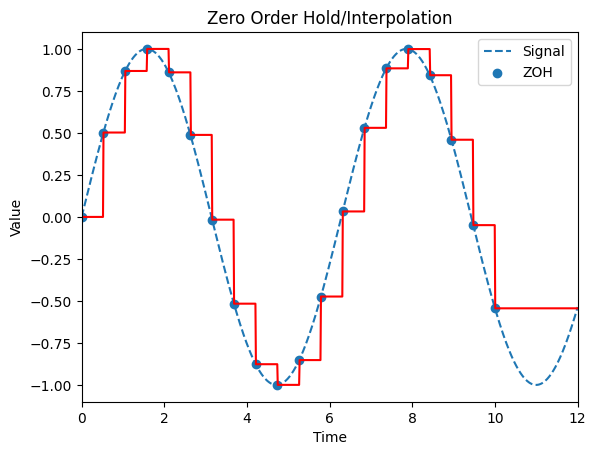

In [3]:
#demonstration

%matplotlib inline

# choose a function
f = np.sin

# sampled signal
xp = np.linspace(0,10,20)
yp = f(xp)

# interpolation grid with 'true' function
x = np.linspace(0,12,1000)
plt.plot(x,f(x),'--')

# plot
plt.scatter(xp,yp)
plt.plot(x,interp0(x,xp,yp),'r')
plt.xlim([x.min(),x.max()])
plt.title('Zero Order Hold/Interpolation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Signal','ZOH'])

Source: [Jckantor's Github](https://jckantor.github.io/CBE30338/08.01-Zero-Order-Hold-and-Interpolation.html)

## Communication Parameters

* The next code will show some data regarding the communication parameters of our system.
* To reason behind several communication parameters, refer to the following picture:

<img src="nyquist_frequency.png" width="500" height="300" />

Source: [Wikipedia](https://en.wikipedia.org/wiki/Nyquist_frequency)

To understand better the relations between data-rate, bandwidth and throughput, watch this [Prof. Iain video](https://www.youtube.com/watch?v=IY6fDYwC2fU&list=PLx7-Q20A1VYIvtMUWX3yd_sQGbQx1qPGP&index=7)

In [4]:
#Generating a 32 samples carrier of 320 us
#No quantization error employed. Assuming infinite resolution 
#Generation communication parameters

R_spi = 1e6 #spi of 1 megabits per second
spi_bits = 10 #resolution of the a/d converter
T_spi = 1/R_spi; #spi clock period
T_s = spi_bits*T_spi #sampling period of zoh
F_s = 1/T_s #sampling frequency

#OFDM parameters
Ncarriers = 32
bits_per_carrier = 1 #1 bit refers to BPSK modulation
bits_per_symbol = bits_per_carrier*Ncarriers
F_nyquist = F_s/2 #available nyquist frequency
B_w = F_nyquist #assuming bandwidth = nyquist limit
B_w_carrier = B_w/Ncarriers
T_sym = 1/B_w_carrier  #total ofdm symbol period duration
T_prefix = T_sym/4 #adding cyclic prefix to OFDM
data_rate_bpbs = bits_per_carrier * Ncarriers/(T_sym + T_prefix) #No FEC applied
# data_rate_bpbs = bits_per_carrier * 3/4 *Ncarriers/(T_sym + T_prefix) #No FEC applied
# 3/4 FEC above. For every 3 bits, we put 4 into the modulator

f_carriers = np.linspace(0,B_w,Ncarriers) #list of carriers

print("SPI clock rate:")
print(qt(T_spi,'s'))
print("ZOH sampling period:")
print(qt(T_s,'s'))
print("ZOH sampling frequency:")
print(qt(F_s,'Hz'))
print("OFDM symbol period:")
print(qt(T_sym,'s'))
print("Number of carriers:")
print(Ncarriers)
print("Nyquist frequency:")
print(qt(F_s/2,'Hz'))
print("Selected OFDM total bandwidth:")
print(qt(B_w,'Hz'))
print("Bandwidth of each carrier:")
print(qt(B_w_carrier,'Hz'))
print("Bits per Carrier:")
print(bits_per_carrier)
print("Theoretical Data-rate:")
print(qt(data_rate_bpbs,'bps'))
print("Carrier frequencies:")
print(f_carriers.tolist())



SPI clock rate:
1 us
ZOH sampling period:
10 us
ZOH sampling frequency:
100 kHz
OFDM symbol period:
640 us
Number of carriers:
32
Nyquist frequency:
50 kHz
Selected OFDM total bandwidth:
50 kHz
Bandwidth of each carrier:
1.5625 kHz
Bits per Carrier:
1
Theoretical Data-rate:
40 kbps
Carrier frequencies:
[0.0, 1612.903225806452, 3225.806451612904, 4838.709677419356, 6451.612903225808, 8064.516129032259, 9677.419354838712, 11290.322580645163, 12903.225806451615, 14516.129032258068, 16129.032258064519, 17741.93548387097, 19354.838709677424, 20967.741935483875, 22580.645161290326, 24193.54838709678, 25806.45161290323, 27419.35483870968, 29032.258064516136, 30645.161290322587, 32258.064516129038, 33870.96774193549, 35483.87096774194, 37096.774193548394, 38709.67741935485, 40322.580645161295, 41935.48387096775, 43548.387096774204, 45161.29032258065, 46774.193548387106, 48387.09677419356, 50000.00000000001]


* To lear more about how the frequency components interact with the time-domain signal performed by the IFFT algorithm, [watch this video of Prof. Iain](https://youtu.be/knjeXo3VZvc)

## Steps in implementing OFDM

The greatest challenge in this endeavour of implementing an online OFDM transmitter in a MCU is to correctly follow the block diagram of the system, and built it digitally on the transmitter. Thus, above I show some steps that need to be taken to implement the transmitter.

(1) The frequency components are drawn from a lookup table with the complex constelation points that would go to the subcarriers.
* This would imply saving in the memory a look up table on the constelation parameters;
* A function on the MCU to format an array of *Ncarriers* length according to the data to be transmitted;
    - The input of the function would be a data of length char, corresponding to 8 bits, or one ASCII character;
    - The output is a complex float array of length *Ncarriers* containing the constelation point at each index; 

(2) The carrier frequency vector is formatted. Each carrier "is carrying" its corresponding symbol. The length of the vector equals Ncarriers;

(3) To this vector, an IFFT/IDFT algorithm is applied, transforming into a sequence of a complex vector of length Ncarriers;
* An FFT algorithm is stored in the memory, along with its corresponding look up tables;
* The output is a complex vector, thus 2 float vectors, of length *Ncarriers*;

(4) Pulse shapping is applied to both real and imaginary parts, by applying a convolution algorithm to a digital filter for pulse shaping. This filter must be design as a FIR or IIR filter, taking into account the sampling frequency of the D/A converter a; the end of the process;
* Several ways to implement this part:
    - 1: Through a convolution algorithm (e.g. sliding tape method) and a look up table of the filter impulse response;
    - 2: FFT of the pulse function (look up table), then multiply to the carrier frequency of step (2) (**sounds easiest**);
    - 3: FIR or IIR filter technique with the time-domain samples created in step (3);

(5) Both real and imaginary parts, now convolved with the pulse shaping filter, are multiplied by a carrier wave signal. The real part is modulated by the cos component at the carrier frequency, while the imaginary part is multiplied by the sin component;
* Simple multiplication algorithm of length *Ncarriers* array with sine and cosine tables of length *Ncarriers* stored in the memory (look up table);

(6) Finally, the two vectors are summed, and the **resulting signal is ready to be send to the D/A converter** process for transmittion.
                                                                                               

## Further References

[Prof. Iain Youtube Playlist on OFDM](https://www.youtube.com/watch?v=F6B4Kyj2rLw&list=PLx7-Q20A1VYIvtMUWX3yd_sQGbQx1qPGP)